# Exercise 4

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [2]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch

    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train()

    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for i, (data, label) in enumerate(train_loader):
        if use_cuda:
            data, label = data.cuda(), label.cuda()

        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()

        # TODO: run the network
        output = model(data)

        # TODO: compute negative log likelihood loss
        loss = F.nll_loss(output, label)

        # TODO: do backpropagation
        loss.backward()

        # TODO: optimize
        optimizer.step()

        # TODO: print current loss for every nth ("log_interval"th) iteration
        if i % log_interval == 0:
            print(
                f"Train Epoch: {epoch} [{i * len(data)}/{len(train_loader.dataset)} "
                f"({100. * i / len(train_loader):.0f}%)]\tLoss: {loss.item()}"
            )

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [3]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics

    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)

    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0

    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()

            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability

            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()

            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()

            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10

                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))

                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0

                # disable axis and show image
                axis[y][x].axis("off")
                axis[y][x].imshow(img)

                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())

                plotted += 1
                img_idx += 1

    test_loss /= len(test_loader.dataset)

    # show results
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [4]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network

    Five fully connected layers with sigmoid non-linearity

    Dimensions
    784->200->100->60->30->10
    """

    def __init__(self):
        super(FCNet1, self).__init__()

        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.linear1 = nn.Linear(784, 200)
        self.activation = nn.Sigmoid()
        self.linear2 = nn.Linear(200, 100)
        self.linear3 = nn.Linear(100, 60)
        self.linear4 = nn.Linear(60, 30)
        self.linear5 = nn.Linear(30, 10)
        self.softmax = F.log_softmax

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(-1, 784)

        # TODO: run network layers
        x = self.activation(self.linear1(x))
        x = self.activation(self.linear2(x))
        x = self.activation(self.linear3(x))
        x = self.activation(self.linear4(x))
        x = self.linear5(x)

        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = self.softmax(x)
        return output

In [5]:
class FCNet2(nn.Module):
    def __init__(self):
        super(FCNet2, self).__init__()
        self.linear1 = nn.Linear(784, 200)
        self.linear2 = nn.Linear(200, 100)
        self.linear3 = nn.Linear(100, 60)
        self.linear4 = nn.Linear(60, 30)
        self.linear5 = nn.Linear(30, 10)
        self.softmax = F.log_softmax
        self.activation = nn.ReLU()
        
    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(-1, 784)

        # TODO: run network layers
        x = self.activation(self.linear1(x))
        x = self.activation(self.linear2(x))
        x = self.activation(self.linear3(x))
        x = self.activation(self.linear4(x))
        x = self.linear5(x)

        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = self.softmax(x)
        return output

In [6]:
class FCNet3(FCNet2):
    def __init__(self):
        super(FCNet3, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(784)
        self.batch_norm3 = nn.BatchNorm1d(100)

    def forward(self, x):
        x.view(-1, 784)

        x = self.batch_norm1(self.linear1(x))
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.batch_norm3(self.linear3(x))
        x = self.activation(x)
        x = self.linear4(x)
        x = self.activation(x)
        x = self.linear5(x)
        
        output = self.softmax(x)
        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [7]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network

    Two convolutional layers and two fully connected layers

    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """

    def __init__(self):
        super(ConvNet1, self).__init__()

        # TODO: initialize network layers
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 13,2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)
        self.activation = nn.ReLU()
        self.softmax = F.log_softmax
        
    def forward(self, x):
        # TODO: run convolutional layers
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(-1, 64 * 12 * 12)
        # TODO: run fully connected layers
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        # TODO: compute log softmax over the output
        output = self.softmax(x)
        return output

In [8]:
class ConvNet2(ConvNet1):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm1d(128)

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.batchnorm1(self.conv1(x))
        x = self.activation(x)
        x = self.activation(self.conv2(x))
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(-1, 64 * 12 * 12)
        # TODO: run fully connected layers
        x = self.batchnorm2(self.fc1(x))
        x = self.activation(x)
        x = self.fc2(x)
        # TODO: compute log softmax over the output
        output = self.softmax(x)
        return output

In [9]:
class ConvNet3(ConvNet2):
    def __init__(self):
        super(ConvNet1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 13) # now use stride =1 (default)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)
        self.activation = nn.ReLU()
        self.softmax = F.log_softmax
        self.maxpool = nn.MaxPool2d(2)
        
    def forward(self, x):
        # TODO: run convolutional layers
        x = self.activation(self.conv1(x))
        x = self.activation(self.maxpool(self.conv2(x)))
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(-1, 64 * 12 * 12)
        # TODO: run fully connected layers
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        # TODO: compute log softmax over the output
        output = self.softmax(x)
        return output

/tmp/ipykernel_11068/1059297260.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.2947263717651367
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.6438428163528442
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.4443776309490204
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.1297469288110733
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.06646419316530228
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.05082624405622482
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.03407621756196022
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.17765755951404572
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.017697690054774284
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.29617926478385925

Test set: Average loss: 0.1181, Accuracy: 9666/10000 (96.66%)



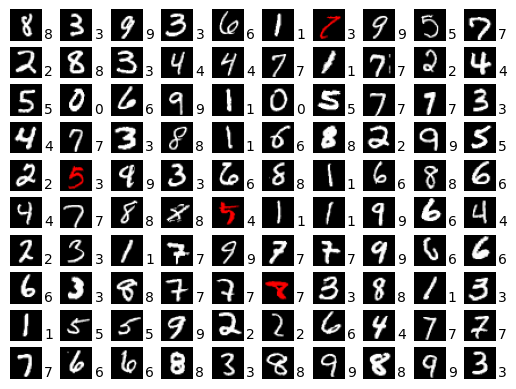

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.02339392900466919
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.1814945936203003
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.06313884258270264
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.022786498069763184
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.04552193731069565
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.2152482122182846
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.111262746155262
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.10349639505147934
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.08904121071100235
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.10948072373867035

Test set: Average loss: 0.0929, Accuracy: 9730/10000 (97.30%)



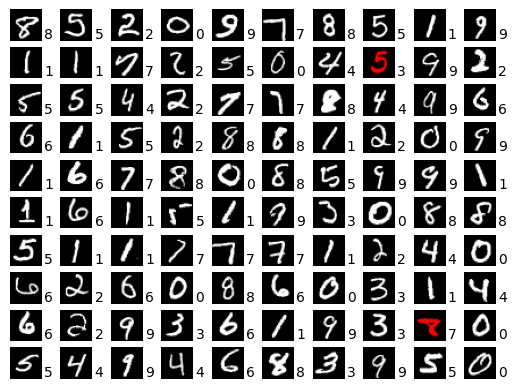

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.07901003956794739
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.07083308696746826
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.02587723918259144
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.08285495638847351
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.0031208726577460766
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.07373199611902237
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.23622068762779236
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.0020236424170434475
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.041241008788347244
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.06374188512563705

Test set: Average loss: 0.0800, Accuracy: 9781/10000 (97.81%)



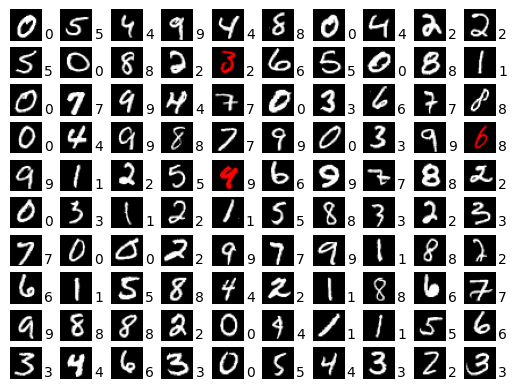

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.015875380486249924
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.12106475234031677
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.005495963152498007
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.1307755708694458
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.024854488670825958
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.028288708999753
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.005670270882546902
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.028992971405386925
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.05364115163683891
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.06226938217878342

Test set: Average loss: 0.0715, Accuracy: 9817/10000 (98.17%)



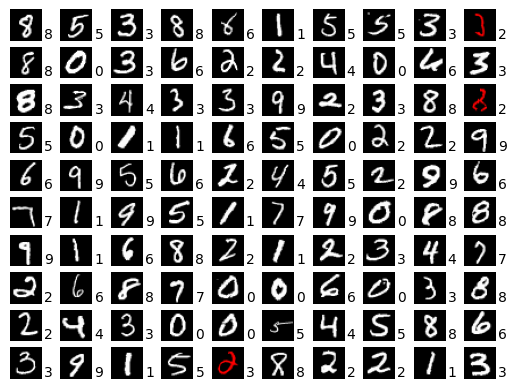

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.003928275778889656
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.015204060822725296
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.0032103632111102343
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.03187377750873566
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.006417783442884684
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.008587954565882683
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.002310045761987567
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.0017895807977765799
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.0015336718643084168
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.002104241633787751

Test set: Average loss: 0.0741, Accuracy: 9817/10000 (98.17%)



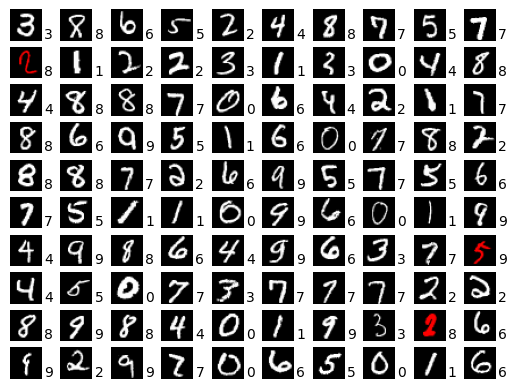

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.010192668996751308
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.009111720137298107
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.015964066609740257
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.09296054393053055
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.0014888668665662408
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.006492801941931248
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.0012138474266976118
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.002611099975183606
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.006005618721246719
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.00040262838592752814

Test set: Average loss: 0.0770, Accuracy: 9836/10000 (98.36%)



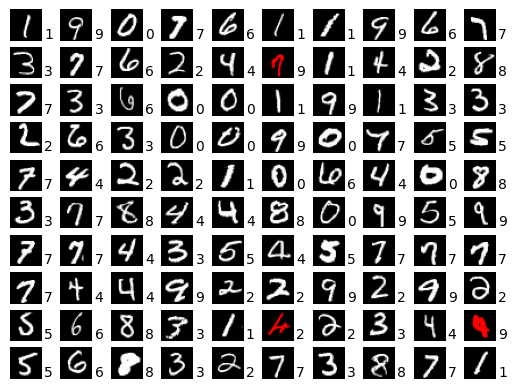

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.003773109056055546
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.0009981804760172963
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.0025210115127265453
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.0015351606998592615
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.003962315618991852
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.0013657491654157639
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.0030540688894689083
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.0013002835912629962
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.008207183331251144
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.0007047903491184115

Test set: Average loss: 0.0792, Accuracy: 9833/10000 (98.33%)



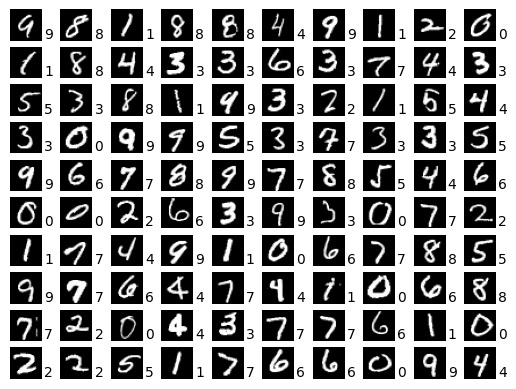

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.00046993745490908623
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.006432864349335432
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.0008815376204438508
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.007081671617925167
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.0005167244817130268
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.00019001525652129203
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.000856385042425245
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.003014894900843501
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.014590002596378326
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.000783081806730479

Test set: Average loss: 0.0828, Accuracy: 9822/10000 (98.22%)



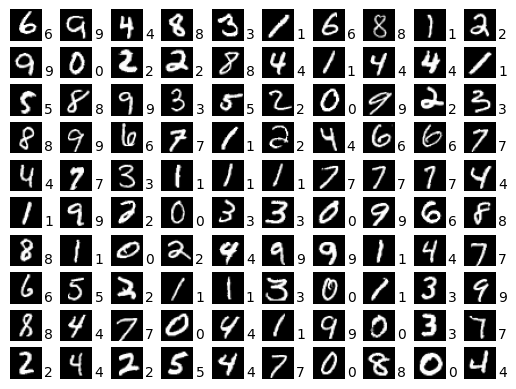

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.0007577865035273135
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.006389055401086807
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.0005073446081951261
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.0011201053857803345
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.0011346553219482303
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.0015585582004860044
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.0017148286569863558
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.0864277258515358
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.0005062069394625723
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.004794043954461813

Test set: Average loss: 0.0854, Accuracy: 9835/10000 (98.35%)



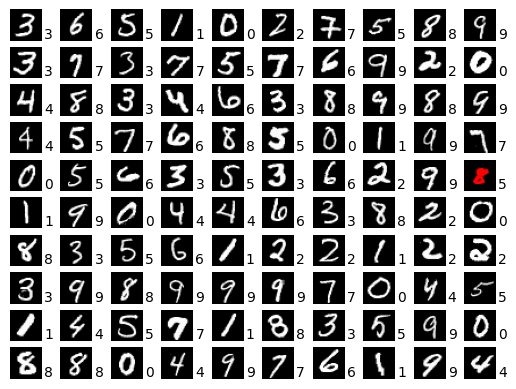

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.0052424161694943905
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.00038775725988671184
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.0057794093154370785
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.018595244735479355
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.0005622875760309398
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.000322277337545529
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.08756205439567566
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.00023670784139540046
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.022558487951755524
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.00022983345843385905

Test set: Average loss: 0.0847, Accuracy: 9829/10000 (98.29%)



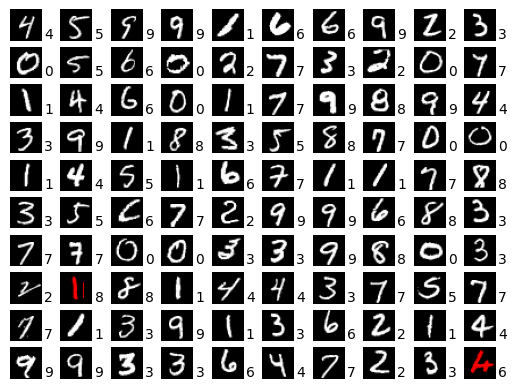

In [10]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
# the line below can be changed
use_cuda = False#torch.cuda.is_available() # Had to change because GPU not supported by torch version
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
    **kwargs,
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../data",
        train=False,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        ),
    ),
    batch_size=test_batch_size,
    shuffle=True,
    **kwargs,
)

model = FCNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)

    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()

    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")